# Regularização

Redes neurais possuem muitos parâmetros, o que torna elas propensas ao sobreajuste (overfitting) dos dados. Dada uma rede suficientemente profunda, sempre é possível obter um modelo perfeito para o conjunto de treinamento. Em geral, isso fará com que o modelo não tenha boa performance em dados não utilizados no treinamento. Portanto, no processo de otimização de uma rede neural é importante tentar evitar que a rede se ajuste demais ao conjunto de treinamento. 

Como já vimos, o treinamento de uma rede envolve um conjunto de treinamento e de validação. Durante o treinamento, é esperado que a loss do conjunto de treinamento fique cada vez menor, possivelmente atingindo o valor 0. Idealmente, queremos que a loss de validação também reduza continuamente durante o treinamento. Um sinal clássico de sobreajuste ocorre quando a loss de validação começa a aumentar durante o treinamento, enquanto que a loss de treinamento continua reduzindo. Isso indica que o modelo está decorando o conjunto de treinamento, e como consequência o modelo está ficando menos generalista.

Técnicas que buscam evitar o sobreajuste do modelo são muitas vezes chamadas de *regularização*. Neste notebook veremos algumas dessas técnicas.

In [1]:
import torch
from torch import nn
from dataset import load_fashion_mnist_small
import train

class Model(nn.Module):
    """Modelo simples para classificação de imagens."""
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return self.layers(x)

# Dataset fashion MNIST com apenas 1 imagem por classe no conjunto de treinamento
ds_train, ds_valid = load_fashion_mnist_small(n_train=10)


### Treinamento com overfit

O conjunto de treinamento possui apenas 10 imagens, o que torna a otimização propensa a gerar um modelo com sobreajuste.

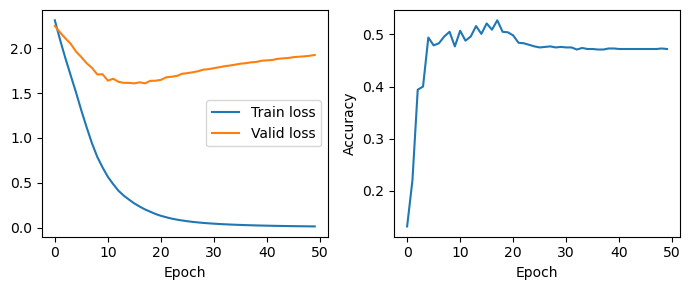

CPU times: total: 1min 8s
Wall time: 18.5 s


In [2]:
%%time
torch.random.manual_seed(0)
model = Model()
bs = 10
num_epochs = 50
lr = 0.1
weight_decay = 0.

logger = train.train(model, ds_train, ds_valid, bs=bs, num_epochs=num_epochs, lr=lr, 
                     weight_decay=weight_decay)
train.show_log(logger)

### Regularização L2 (weight decay)

A regularização L2 consiste em forçar os pesos da rede a possuírem valores próximos de zero. Isso força uma superfície de decisão suave para o modelo. Veja o capítulo 1.3 das notas de aula para entender melhor a ideia desse tipo de regularização.

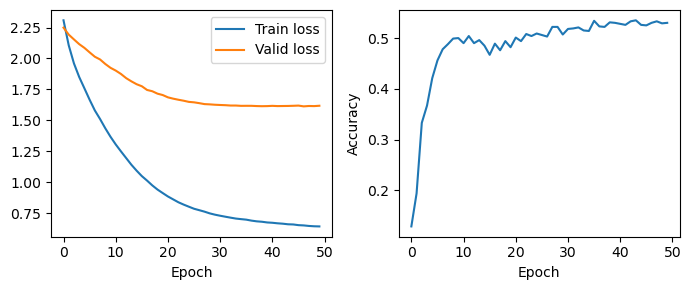

CPU times: total: 1min 9s
Wall time: 19.4 s


In [15]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs=bs, num_epochs=num_epochs, lr=lr, 
                     weight_decay=0.4)
train.show_log(logger)

### Efeito de regularização do batch size

O treinamento da rede com um batch size menor também possui um efeito de regularização.

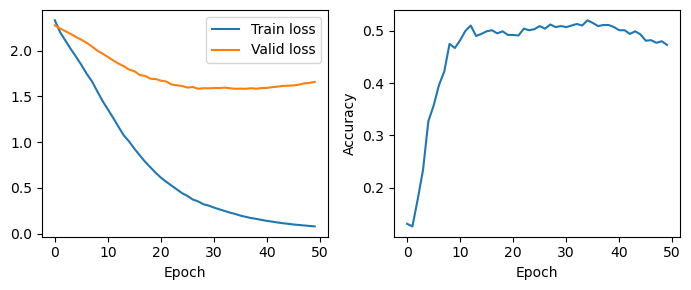

CPU times: total: 1min 38s
Wall time: 26 s


In [16]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs=2, num_epochs=num_epochs, lr=0.01, 
                     weight_decay=weight_decay)
train.show_log(logger)

### Dropout

#### Entendendo a camada Dropout

A camada dropout remove aleatoriamente alguns valores de entrada. Mas após a remoção o resultado de operações após a camada podem acabar reduzindo de valor. Para evitar isso, a camada reescala os valores.

In [17]:
p = 0.5
drop = nn.Dropout(p)
x = torch.tensor([1, 2, 3, 4, 5, 6], dtype=torch.float32)
y = drop(x)
print(y)

tensor([2., 0., 0., 8., 0., 0.])


In [31]:
# Valores removidos pela camada Dropout
mask = y>0
# Remove os mesmos valores que a camada Dropout acima
x_drop = x*mask
# Reescala os valores
yc = x_drop/(1-p)
print(yc)

tensor([2., 0., 0., 8., 0., 0.])


In [32]:
drop.eval()
y = drop(x)
print(y)

tensor([1., 2., 3., 4., 5., 6.])


#### Adicionando Dropout ao modelo

Dropout possui uma analogia com a técnica de boosting em machine learning. Para a rede ter boa performance, ela precisa ter diversas "subredes" que classificam bem as imagens, pois atributos são aleatoriamente apagados. 

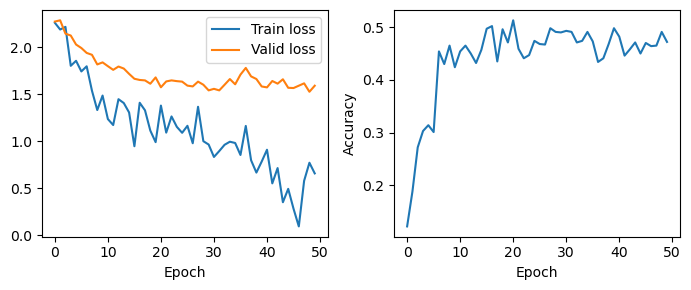

CPU times: total: 1min 9s
Wall time: 18.6 s


In [6]:
%%time
class ModelDrop(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(512, 16),
            nn.ReLU(),
            nn.Dropout(0.5),          
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return self.layers(x)

torch.random.manual_seed(0)
model = ModelDrop()

logger = train.train(model, ds_train, ds_valid, bs=bs, num_epochs=num_epochs, lr=lr, 
                     weight_decay=weight_decay)
train.show_log(logger)

### Aumento de dados

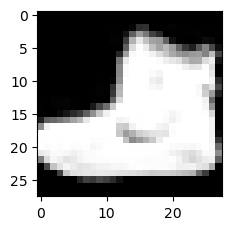

In [43]:
import matplotlib.pyplot as plt

ds_train, ds_valid = load_fashion_mnist_small(n_train=10, augment=True)
plt.imshow(ds_train[0][0][0], 'gray')

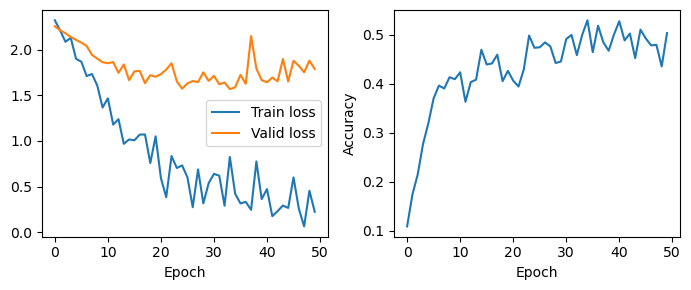

CPU times: total: 2min 33s
Wall time: 40.4 s


In [8]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs=bs, num_epochs=num_epochs, lr=lr, 
                     weight_decay=weight_decay)
train.show_log(logger)

### Unindo todas as técnicas

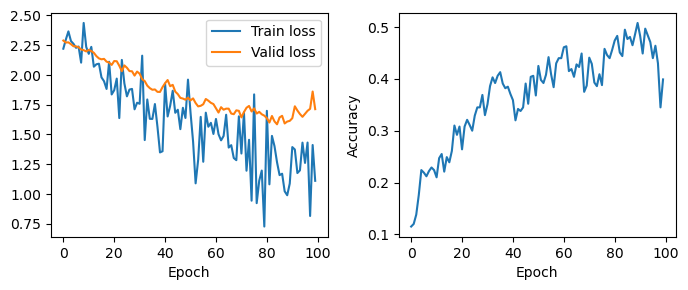

In [10]:
torch.random.manual_seed(0)
model = ModelDrop()

logger = train.train(model, ds_train, ds_valid, bs=8, num_epochs=100, lr=0.02, 
                     weight_decay=0.01)
train.show_log(logger)